## Flowers Recognition 

The Oxford Flowers 102 dataset is a collection of 102 flower categories commonly occurring in the United 
Kingdom. Each class consists of between 40 and 258 images. The images have large scale, pose and light 
variations. In addition, there are categories that have large variations within the category and several very 
similar categories. 
The dataset is divided into a training set, a validation set and a test set. The training set and validation set 
each consist of 10 images per class (a total of 1020 images each). The test set consists of the remaining 
6149 images (minimum 20 per class). Some tasks to consider: 
1. Modify some previously published architectures e.g., increase the network depth, reducing their 
parameters,  etc.  Explore  more  advanced  techniques  such  as  deformable  convolution,  dilated 
convolution (dilation>1) or visual prompt tuning for Transformers. 
2. Analyze the results of using fewer training images, i.e., few-shot learning 
3. Use  more  advanced  transformation  techniques  such  as  MixUp  (see  the  original  paper  and  its 
PyTorch implementation here) 
4. Try more advanced loss function such as triplet loss

In [30]:
import platform
# Requires virtual env to be set up first.
if platform.system() == "Darwin":  # macOS
    %pip install -r requirements_mac.txt
else:
    %pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu124
Note: you may need to restart the kernel to use updated packages.


## 1. Environment Setup

This section setups the environment by doing the following:
1. Importing the dependencies
2. Checking if CUDA/mps is available on device running this notebook
3. Setting up data and output folder to store downloaded dataset and outputs
4. Setting up of transforms for data augmentation
5. Downloading of datasets after transforms are initialized
6. Setting up of hyper parameters for training
7. Creation of dataloaders and visualizing data

### 1. Importing the dependencies

In [31]:
# Import necessary libraries
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm 
import pandas as pd

# Torch dependencies
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchsummary import summary  # For model architecture visualization

# Custom utility files
import src.data_utils as data_utils
import src.visualization as visualization
import src.model_utils as model_utils

# Sets default seeds to 42 for reproducibility
data_utils.set_seeds()

### 2. Checking if CUDA/mps is available

In [32]:
# Set the device based on availability of MPS (macOS), CUDA, or CPU
device = torch.device("mps" if torch.backends.mps.is_available() else 
                      "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### 3. Setting up data and output folders to store downloaded dataset and output later on

In [33]:
# Define the data directories to store dataset and outputs
data_dir = "./data"
output_dir = "./output" 
save_dir = output_dir + "/saved_models"  # Directory to save trained models

# Create directories if they do not exist
os.makedirs(data_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

### 4. Image Transforms and Augmentation
In the training transform, it is normalized to those values instead of (0.5, 0.5, 0.5) for both std and mean as it is common practice and was calculated based on millions of images. So we will try that for now.

Ref: https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2

In [34]:
data_transforms = data_utils.get_data_transforms()
display(data_transforms)

{'train': Compose(
     RandomResizedCrop(size=(224, 224), scale=(0.7, 1.0), ratio=(0.75, 1.33), interpolation=bilinear, antialias=True)
     RandomHorizontalFlip(p=0.5)
     RandomVerticalFlip(p=0.2)
     RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
     ColorJitter(brightness=(0.85, 1.15), contrast=(0.85, 1.15), saturation=(0.85, 1.15), hue=(-0.15, 0.15))
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 ),
 'val_test': Compose(
     Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
     CenterCrop(size=(224, 224))
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 )}

### 5. Dataset Downloading
- Load the Oxford Flowers 102 dataset which is split into the following:
  - Training : 10 image per class (1020 images)
  - Validation : 10 image per class (1020 images)
  - Test set : remaining images (6149 images)

In [35]:
# Download the dataset
flowers_dataset = data_utils.load_flowers102_dataset(data_dir)
display(flowers_dataset)

Train set size: 1020
Validation set size: 1020
Test set size: 6149


{'train': Dataset Flowers102
     Number of datapoints: 1020
     Root location: ./data
     split=train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.7, 1.0), ratio=(0.75, 1.33), interpolation=bilinear, antialias=True)
                RandomHorizontalFlip(p=0.5)
                RandomVerticalFlip(p=0.2)
                RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
                ColorJitter(brightness=(0.85, 1.15), contrast=(0.85, 1.15), saturation=(0.85, 1.15), hue=(-0.15, 0.15))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'val': Dataset Flowers102
     Number of datapoints: 1020
     Root location: ./data
     split=val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
                CenterCrop(size=(224, 224))
                T

The actual labels were acquired from https://gist.github.com/JosephKJ/94c7728ed1a8e0cd87fe6a029769cde1.
We use this to map the actual label to the flower name for better visualisation rather than reading something as 'Flower 1' or 'Flower 27'

In [36]:
flower_labels = data_utils.get_flower_labels("flower_labels.txt")
# Convert the labels to a pandas DataFrame
flower_labels_df = pd.DataFrame(flower_labels, columns=["Flower Name"])
display(flower_labels_df)

,Flower Name
0,pink primrose
1,hard-leaved pocket orchid
2,canterbury bells
3,sweet pea
4,english marigold
...,...
97,mexican petunia
98,bromelia
99,blanket flower
100,trumpet creeper


### 6. Hyperparameters Setup

In [37]:
# Hyperparameters setup
BATCH_SIZE = 32
NUM_EPOCHS = 25
LEARNING_RATE = 0.001
NUM_CLASSES = 102 # Number of classes in the dataset, Oxford 102 has 102 classes 

### 7. Creation of dataloaders and visualizing data

In [38]:
# Create our dataloaders for batching and iterators
data_loaders = data_utils.create_dataloaders(datasets_dict=flowers_dataset, batch_size=BATCH_SIZE, num_workers=4)

# Store our dataset sizes in a dictionary for easy access
dataset_sizes = {
    'train': len(data_loaders['train'].dataset),
    'val': len(data_loaders['val'].dataset),
    'test': len(data_loaders['test'].dataset)
}
display(dataset_sizes)

{'train': 1020, 'val': 1020, 'test': 6149}

This section visualizes samples from our training dataset, showing the original image, the augmented image as well as an example of the "most augmented" image that has the most "different" feature vector from the original to visualize what a good augmented image would look like. The most augmented image is just an example given our initial transforms.

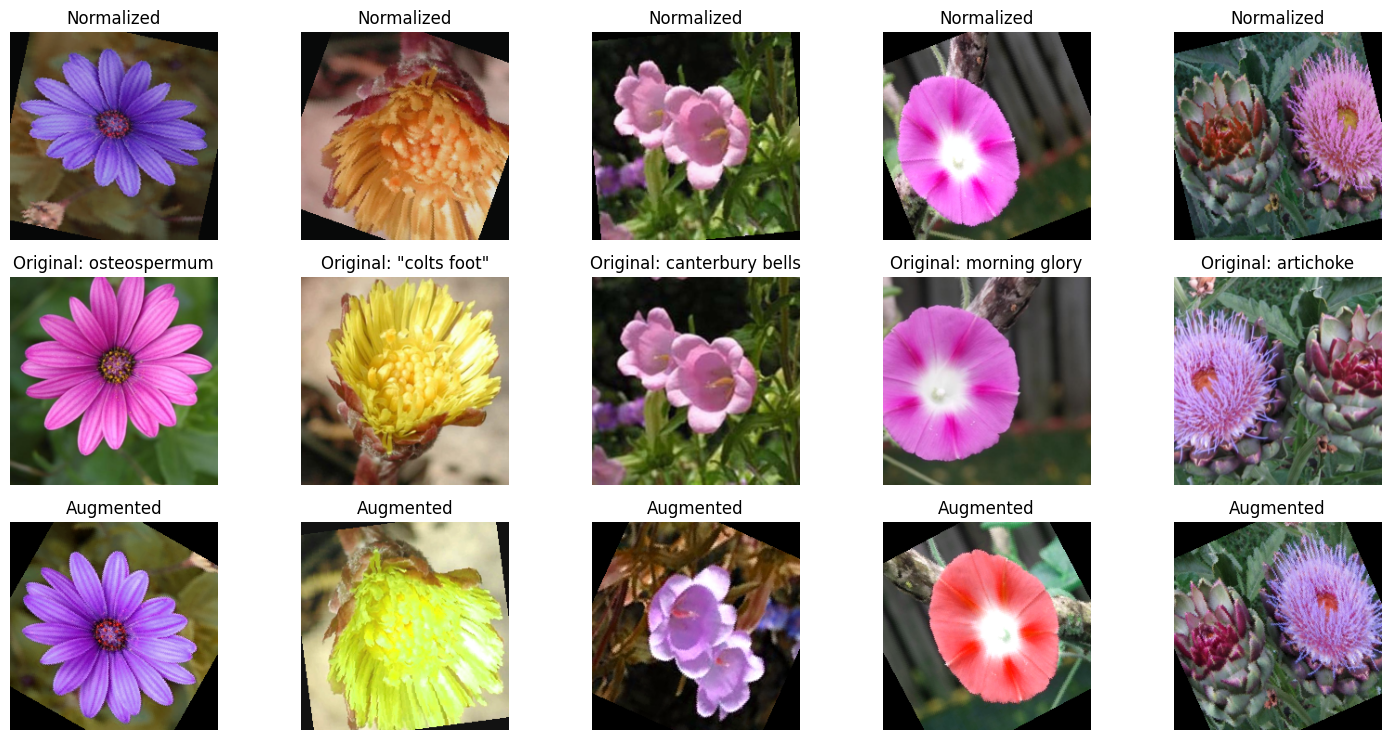

In [39]:
# Visualize a few samples from the training dataset
visualization.visualize_dataset_samples(flowers_dataset['train'], flower_labels, num_samples=5, show_augmented=True)

### 8. Declare Utility Functions

In [40]:
def display_model_architecture(model, device):
    """
    Display model architecture summary including layers and parameters.
    
    Args:
        model (nn.Module): PyTorch model to display
        device (torch.device): Device the model is running on
    
    Returns:
        None: Prints model architecture information
    """
    if hasattr(model, "model_name"):
        print(f"Model Architecture: {model.model_name}")
    else:
        print(f"\nModel Architecture: {model.__class__.__name__}")
    try:
        summary(model, (3, 224, 224), device=device.type)
    except Exception as e:
        print(f"Could not generate detailed summary: {e}")
        print(model)

def display_model_parameters(model):
    """
    Calculate and display parameter statistics for the model.
    
    Args:
        model (nn.Module): PyTorch model to analyze
    
    Returns:
        tuple: (total_params, trainable_params, non_trainable_params)
    """
    # Calculate parameter count
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params

    print(f"\nModel Parameter Information:")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Non-trainable parameters: {non_trainable_params:,}")
    
    return total_params, trainable_params, non_trainable_params

## Training and evaluating the model

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.


The `train_model` function is designed to train and evaluate a given neural network model over a specified number of epochs.

### Parameters:

- **model**: The neural network model to be trained.
- **criterion**: The loss function.
- **optimizer**: The optimization algorithm.
- **scheduler**: Adjusts the learning rate based on the number of epochs.
- **num_epochs**: Number of times the model will be trained over the entire dataset (default is 25).

### Process:

1. **Time Tracking**:
    - The start time is recorded to calculate the total training time at the end.

2. **Temporary Directory for Checkpoints**:
    - A temporary directory is created to save the best model parameters during training.

3. **Training Loop**:
    - For each epoch:
        - The model is trained on the training dataset and evaluated on the validation dataset.
        - Depending on the phase (`train` or `val`), the model is set to the appropriate mode using `model.train()` or `model.eval()`.
        - The gradients are zeroed out at the beginning of each batch using `optimizer.zero_grad()`.
        - The model's predictions are compared to the actual labels to compute the loss.
        - If in the training phase, backpropagation is performed and the optimizer updates the model's parameters.
        - Running statistics like loss and accuracy are computed for each epoch.
        - If in the training phase, the learning rate scheduler adjusts the learning rate.
        - The best model (based on validation accuracy) is saved to the temporary directory.

4. **Results**:
    - After all epochs are completed, the total training time is printed.
    - The best validation accuracy achieved during training is also printed.

5. **Load Best Model**:
    - The best model parameters saved during training are loaded back into the model.

6. **Return**:
    - The trained model with the best parameters is returned.

By using this function, one can easily train and evaluate a neural network model, ensuring that the best version of the model (in terms of validation accuracy) is retained.



In [41]:
from tempfile import TemporaryDirectory
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=25):
    """
    Train the model
    
    Args:
        model: The model to train
        criterion: Loss function
        optimizer: Optimizer for updating weights
        scheduler: Learning rate scheduler
        dataloaders: Dictionary containing 'train' and 'val' dataloaders
        dataset_sizes: Dictionary with sizes of 'train' and 'val' datasets
        num_epochs: Number of epochs to train
        
    Returns:
        model: Trained model with best weights
    """
    since = time.time()
    device = next(model.parameters()).device
    
    # Track training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'time_taken' : None,
    }

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch + 1}/{num_epochs}')
            print('-' * 20)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in tqdm(dataloaders[phase], desc=phase):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                epoch_loss = running_loss / dataset_sizes[phase]
                if device.type == 'mps':
                    # Mps does not support float64
                    epoch_acc = running_corrects.float() / dataset_sizes[phase]
                else:
                    epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                if phase == 'train':
                    print(f'Learning Rate: {scheduler.get_last_lr()[0]:.6f}')
                
                # Store history
                if phase == 'train':
                    history['train_loss'].append(epoch_loss)
                    history['train_acc'].append(epoch_acc.item())
                else:
                    history['val_loss'].append(epoch_loss)
                    history['val_acc'].append(epoch_acc.item())
                    # Update scheduler based on validation loss
                    scheduler.step(epoch_loss)

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))

        # Update end time taken
        history['time_taken'] = time_elapsed;
        
    return model, history

In [42]:
def evaluate_model(model, criterion, data_loader):
    """
    Evaluate the model on the test set
    
    Args:
        model: The model to evaluate
        criterion: Loss function
        data_loader: DataLoader for the test dataset
        
    Returns:
        test_loss: The average loss on the test set
        test_acc: The accuracy on the test set
        all_preds: List of all predictions
        all_labels: List of all true labels
    """
    device = next(model.parameters()).device
    model.eval()
    
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []
    
    # No gradient computation needed for evaluation
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            # Store predictions and labels for further analysis
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate test loss and accuracy
    dataset_size = len(data_loader.dataset)
    test_loss = running_loss / dataset_size
    test_acc = running_corrects.float() / dataset_size
    
    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')
    
    return test_loss, test_acc, all_preds, all_labels

### Training Setup
This section sets up the optimizer, criterion, and scheduler that will be used for the experiments.

We use CrossEntropyLoss as our criterion since we're dealing with multi-class classification. For optimization, we use Adam with an initial learning rate of LEARNING_RATE. Adam typically converges faster than SGD for many deep learning tasks by adaptively adjusting the learning rates of individual parameters.

To improve training dynamics, we implement a ReduceLROnPlateau scheduler, which reduces the learning rate by a factor of 0.1 when the validation loss stops improving for 3 consecutive epochs. This approach helps the model converge more effectively, especially when training reaches a plateau.

In [43]:
criterion = nn.CrossEntropyLoss()  # Loss function for multi-class classification

def get_optimizer_and_scheduler(model):
    # Using Adam optimizer
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
    # optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    # Learning rate scheduler - reduce learning rate when validation loss plateaus
    # patience=3: wait for 3 epochs with no improvement before reducing LR
    # factor=0.1: multiply learning rate by 0.1 when reducing
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, min_lr=1e-6,threshold=0.005, verbose=True)
    return optimizer, scheduler

In [44]:
# Add code for loading and training models
def load_or_train_model(model_name, model_class, save_dir, device, **kwargs):  
    # Attempt to load from previous
    if model_utils.check_model_exists(model_name =model_name, save_dir=save_dir):
        print(f"Loading existing model: {model_name}")
        # Load the pre-trained model and its history
        model, history = model_utils.load_model_and_history(
            model_class=model_class, 
            model_name=model_name, 
            num_classes=NUM_CLASSES, 
            save_dir=save_dir,
            device=device
        )
        
        # Display the architecture and parameters of the loaded model
        display_model_architecture(model, device)
        display_model_parameters(model)
        
        print("Model loaded successfully! Skipping training phase.")
    else:
        print(f"No existing model found. Initializing and training new model: {model_name}")
        
        # Initialize the model using the model class
        model = model_class(model_name=model_name, **kwargs)
        model = model.to(device)  # Send to GPU if possible
        
        # Show the parameters and architecture of the model
        display_model_architecture(model, device)
        display_model_parameters(model)
        
        # Initialize optimizer and scheduler
        optimizer, scheduler = get_optimizer_and_scheduler(model)
        
        # Train the model
        model, history = train_model(
            model=model, 
            criterion=criterion, 
            optimizer=optimizer, 
            scheduler=scheduler, 
            dataloaders=data_loaders, 
            dataset_sizes=dataset_sizes, 
            num_epochs=NUM_EPOCHS
        )
        
        # Save the model after training
        model_utils.save_model_and_history(model, history, model_name=model_name, save_dir=save_dir)
        
        print(f"Model trained and saved successfully!")
    
    return model, history

## Training Base Models without Architecture Modification

The following models are trained without any modifications to architecture to see the raw performance towards the dataset.

The models being trained are:
1. Our light weight baseline CNN model with minimal parameters
2. Pre-trained Resnet18 with fine tuning of last conv block and fc layer
3. Pre-trained Resnet50 with fine tuning of last conv block and fc layer
4. ViT model w prompt tuning

In [45]:
# Setup directory of base models
base_models_dir = save_dir + "/base"

### Model 1: Base CNN Model
This model is our lightweight baseline CNN model with some conv blocks so as to have a rough gauge on how a small model works against a dataset with minimal training images.

In [46]:
from src.models.base_cnn import BaseCNN

# Load or train the model
base_cnn, base_cnn_history = load_or_train_model(
    model_name="base_cnn",
    model_class=BaseCNN,
    save_dir=base_models_dir,
    device=device
)

Loading existing model: base_cnn
Model loaded from ./output/saved_models/base\base_cnn.pth
Model Architecture: base_cnn
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          18,496
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
        MaxPool2d-11          [-1, 128, 56, 56]               0
           Conv2d-12          [-1, 192, 56, 56]

c:\Users\isaac\Documents\GitHub\flowers-recognition\src\model_utils.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_loc

Testing:   0%|          | 0/193 [00:00<?, ?it/s]

Test Loss: 3.1772 Acc: 0.2428
Final Test Accuracy: 0.2428
Final Test Loss: 3.1772


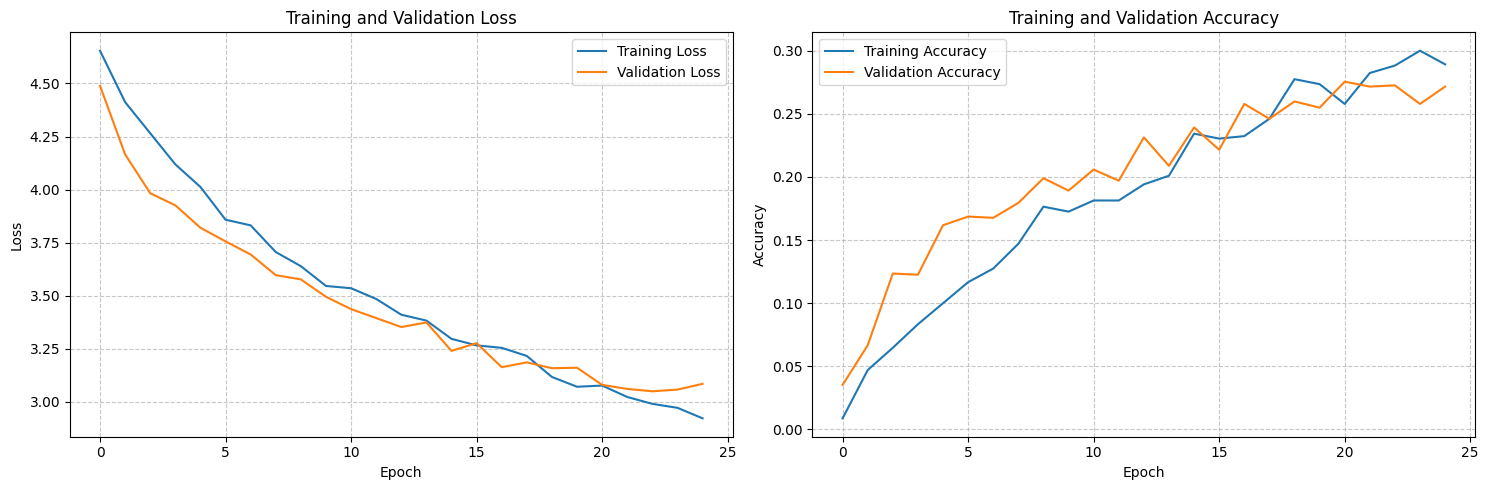

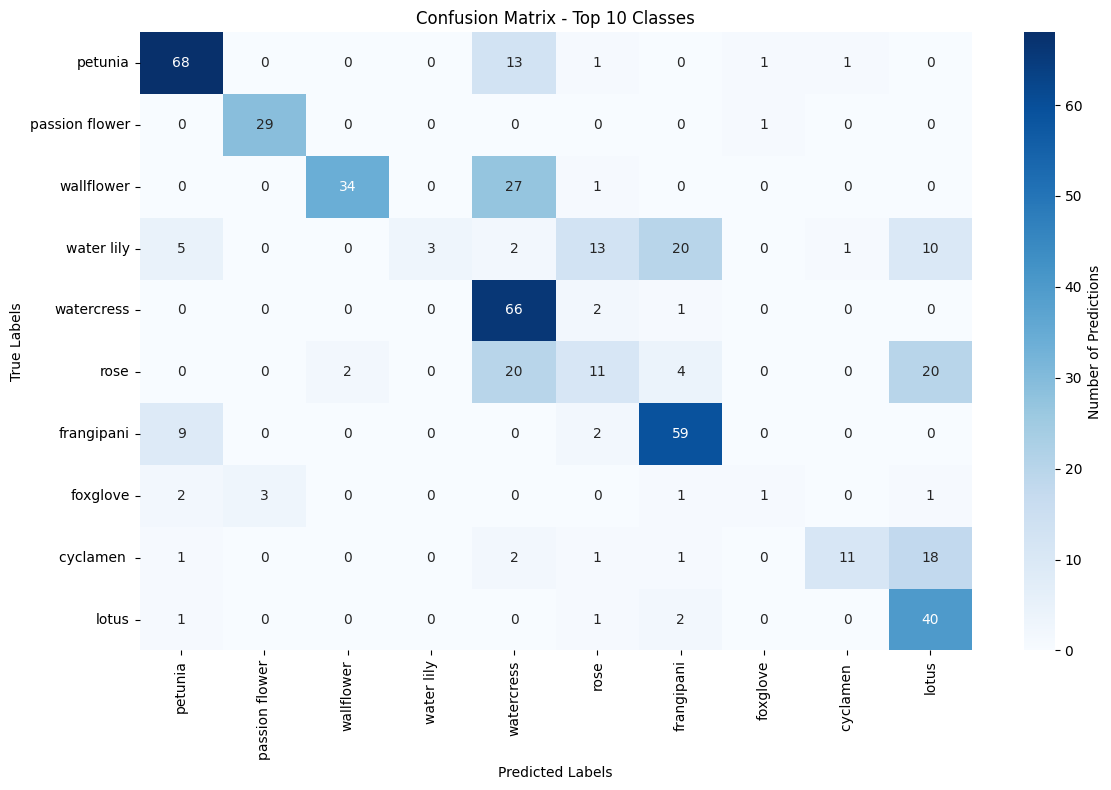

Classification Report - Top 10 Classes:
                precision    recall  f1-score   support

       petunia       0.79      0.81      0.80        84
passion flower       0.91      0.97      0.94        30
    wallflower       0.94      0.55      0.69        62
    water lily       1.00      0.06      0.11        54
    watercress       0.51      0.96      0.66        69
          rose       0.34      0.19      0.25        57
    frangipani       0.67      0.84      0.75        70
      foxglove       0.33      0.12      0.18         8
     cyclamen        0.85      0.32      0.47        34
         lotus       0.45      0.91      0.60        44

      accuracy                           0.63       512
     macro avg       0.68      0.57      0.54       512
  weighted avg       0.70      0.63      0.59       512



In [47]:
# Evaluate the model on the test set
base_cnn_test_loss, base_cnn_test_acc, all_preds, all_labels = evaluate_model(base_cnn, criterion, data_loaders['test'])

# Print final results
print(f"Final Test Accuracy: {base_cnn_test_acc:.4f}")
print(f"Final Test Loss: {base_cnn_test_loss:.4f}")

# Plot training history
visualization.plot_training_history(base_cnn_history)
# Plot confusion matrix
visualization.plot_top_n_confusion_matrix(all_labels, all_preds, flower_labels, top_n=10)

In [48]:
#visualization.visualize_misclassifications_with_closest_images(base_cnn, data_loaders['test'], flower_labels, flowers_dataset['test'])

### Model 2: Pretrained Model: Resnet 18
We use resnet18 pretrained model and freeze all layers except last conv block and fully connected layers for transfer learning to capture more intrinsic details that exist through these flowers.

In [49]:
from src.models.base_pretrained_model import BasePretrainedModel

# Load or train the model
base_resnet18, base_resnet18_history = load_or_train_model(
    model_name="resnet18",
    model_class=BasePretrainedModel,
    save_dir=base_models_dir,
    device=device,
    num_classes =NUM_CLASSES,
    freeze_strategy="layer4", # Freeze all except last conv block and fully connected layer
)

Loading existing model: resnet18
Model loaded from ./output/saved_models/base\resnet18.pth
Model Architecture: resnet18
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]

c:\Users\isaac\Documents\GitHub\flowers-recognition\src\model_utils.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_loc

Testing:   0%|          | 0/193 [00:00<?, ?it/s]

Test Loss: 0.9770 Acc: 0.7949
Final Test Accuracy: 0.7949
Final Test Loss: 0.9770


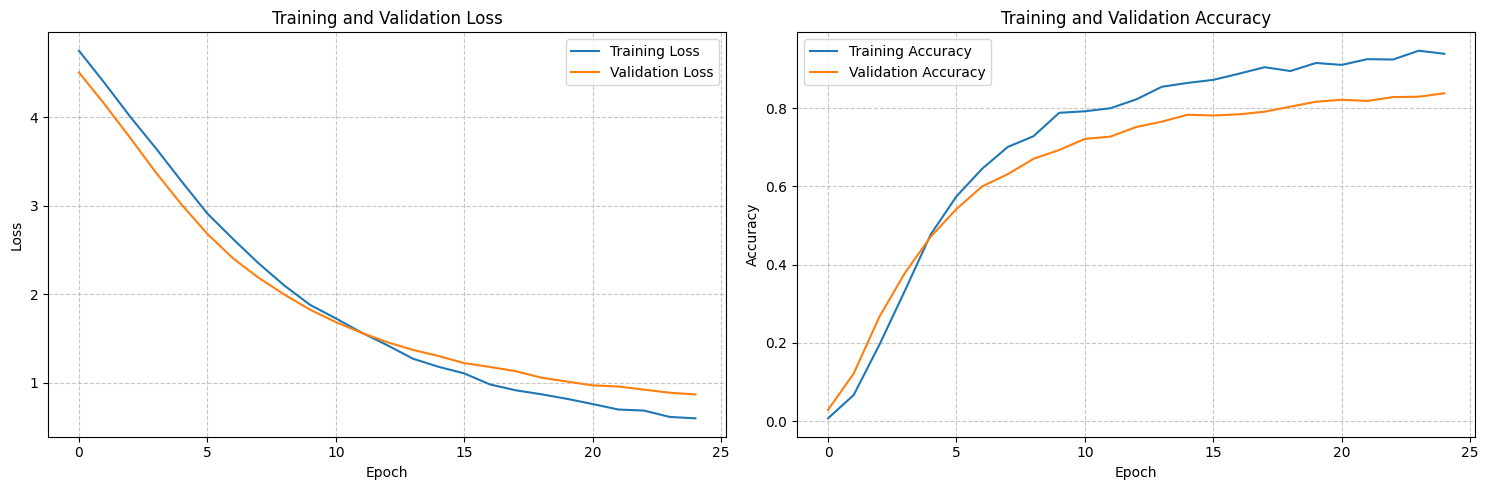

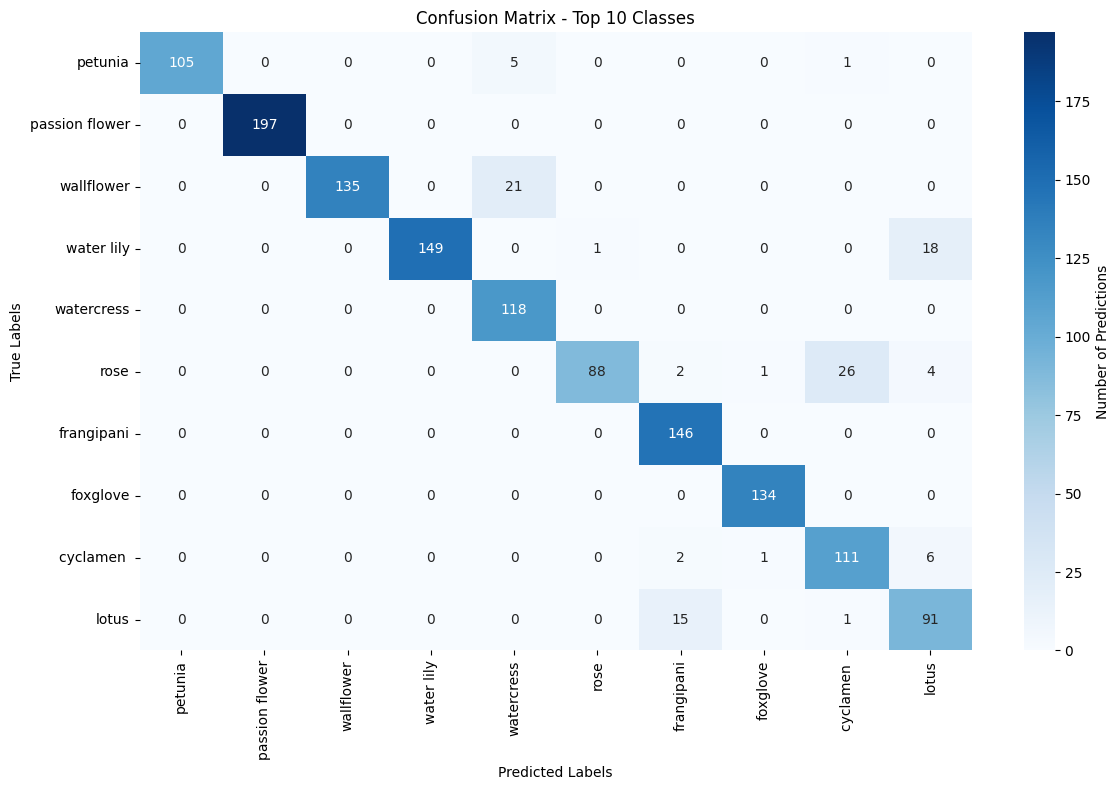

Classification Report - Top 10 Classes:
                precision    recall  f1-score   support

       petunia       1.00      0.95      0.97       111
passion flower       1.00      1.00      1.00       197
    wallflower       1.00      0.87      0.93       156
    water lily       1.00      0.89      0.94       168
    watercress       0.82      1.00      0.90       118
          rose       0.99      0.73      0.84       121
    frangipani       0.88      1.00      0.94       146
      foxglove       0.99      1.00      0.99       134
     cyclamen        0.80      0.93      0.86       120
         lotus       0.76      0.85      0.81       107

      accuracy                           0.92      1378
     macro avg       0.92      0.92      0.92      1378
  weighted avg       0.93      0.92      0.92      1378



In [50]:
# Evaluate the resnet18 on the test set
base_resnet18_test_loss, base_resnet18_test_acc, all_preds, all_labels = evaluate_model(base_resnet18, criterion, data_loaders['test'])

# Print final results
print(f"Final Test Accuracy: {base_resnet18_test_acc:.4f}")
print(f"Final Test Loss: {base_resnet18_test_loss:.4f}")

# Plot training history
visualization.plot_training_history(base_resnet18_history)
# Plot confusion matrix
visualization.plot_top_n_confusion_matrix(all_labels, all_preds, flower_labels, top_n=10)

In [51]:
#  visualization.visualize_misclassifications_with_closest_images(base_resnet18, data_loaders['test'], flower_labels, flowers_dataset['test'])

### Model 3: Pretrained Model: Resnet 50
In this model, we expect accuracy to be higher as there are more layers, which should help capture the more intricate details of the flowers.

In [52]:
from src.models.base_pretrained_model import BasePretrainedModel

# Load or train the model
base_resnet50, base_resnet50_history = load_or_train_model(
    model_name="resnet50",
    model_class=BasePretrainedModel,
    save_dir=base_models_dir,
    device=device,
    num_classes =NUM_CLASSES,
    freeze_strategy="layer4", # Freeze all except last conv block and fully connected layer
)

Loading existing model: resnet50
Model loaded from ./output/saved_models/base\resnet50.pth
Model Architecture: resnet50
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]

c:\Users\isaac\Documents\GitHub\flowers-recognition\src\model_utils.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_loc

Testing:   0%|          | 0/193 [00:00<?, ?it/s]

Test Loss: 0.7414 Acc: 0.8357
Final Test Accuracy: 0.8357
Final Test Loss: 0.7414


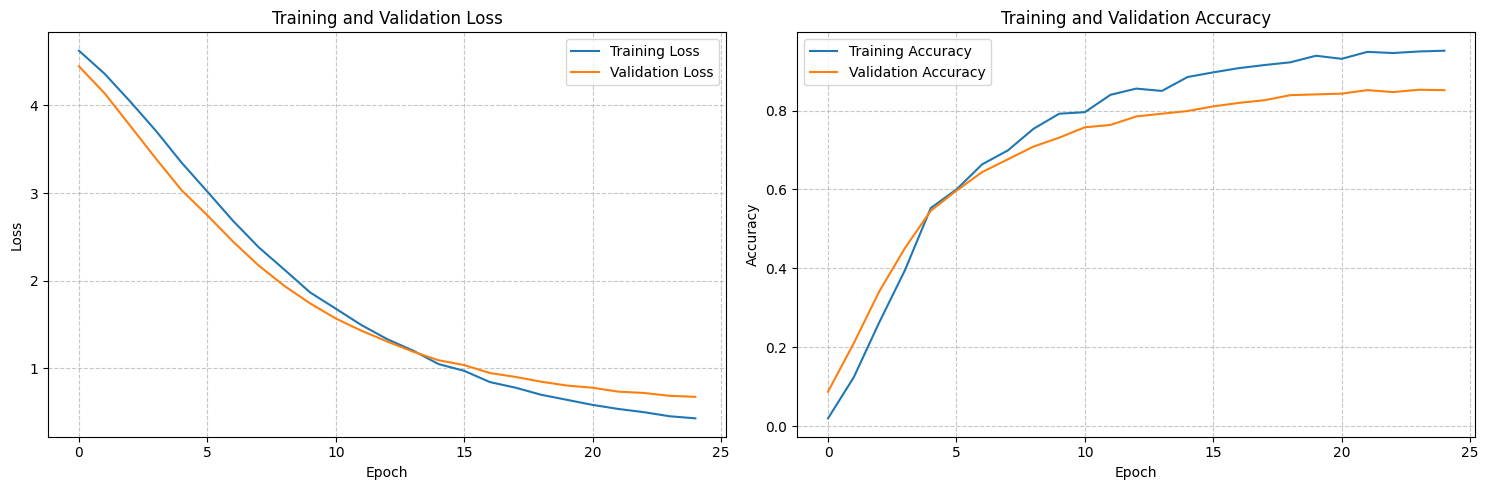

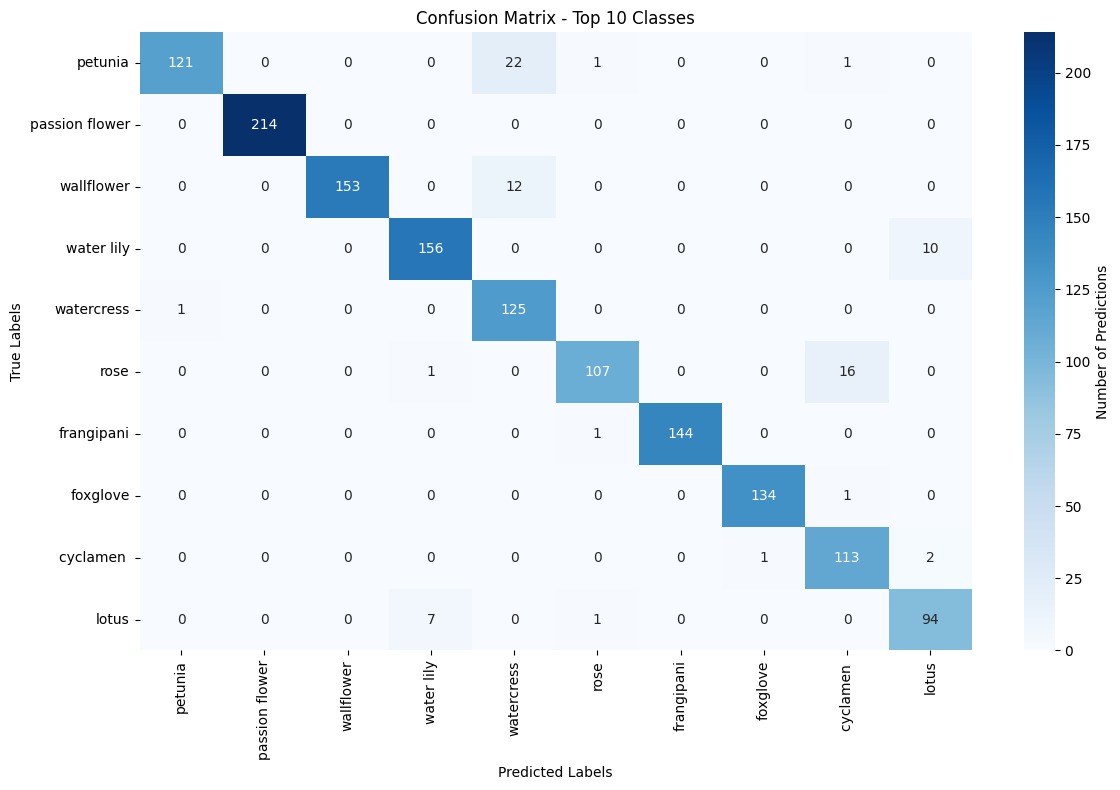

Classification Report - Top 10 Classes:
                precision    recall  f1-score   support

       petunia       0.99      0.83      0.91       145
passion flower       1.00      1.00      1.00       214
    wallflower       1.00      0.93      0.96       165
    water lily       0.95      0.94      0.95       166
    watercress       0.79      0.99      0.88       126
          rose       0.97      0.86      0.91       124
    frangipani       1.00      0.99      1.00       145
      foxglove       0.99      0.99      0.99       135
     cyclamen        0.86      0.97      0.91       116
         lotus       0.89      0.92      0.90       102

      accuracy                           0.95      1438
     macro avg       0.94      0.94      0.94      1438
  weighted avg       0.95      0.95      0.95      1438



In [53]:
# Evaluate the resnet50 on the test set
base_resnet50_test_loss, base_resnet50_test_acc, all_preds, all_labels = evaluate_model(base_resnet50, criterion, data_loaders['test'])

# Print final results
print(f"Final Test Accuracy: {base_resnet50_test_acc:.4f}")
print(f"Final Test Loss: {base_resnet50_test_loss:.4f}")

# Plot training history
visualization.plot_training_history(base_resnet50_history)
# Plot confusion matrix
visualization.plot_top_n_confusion_matrix(all_labels, all_preds, flower_labels, top_n=10)

In [54]:
#visualization.visualize_misclassifications_with_closest_images(base_resnet50, data_loaders['test'], flower_labels, flowers_dataset['test'])

### Model 4: Visual Transformer w Prompt Tuning
- INSERT desc

In [55]:
# # Set up the model, optimizer and scheduler for training and evaluation
# from src.models.vit_base_model import VisualPromptTransformer

# # Initialize the model and history as None first
# model_name = "vit_b_16"

# # Load or train the model
# base_vit, base_vit_history = load_or_train_model(
#     model_name=model_name,
#     model_class=VisualPromptTransformer,
#     save_dir=save_dir,
#     device=device,
#     num_classes=NUM_CLASSES
# )

In [56]:
# # Evaluate the vit on the test set
# base_vit_test_loss, base_vit_test_acc, all_preds, all_labels = evaluate_model(base_vit, criterion, data_loaders['test'])

# # Print final results
# print(f"Final Test Accuracy: {base_vit_test_acc:.4f}")
# print(f"Final Test Loss: {base_vit_test_loss:.4f}")

# # Plot training history
# visualization.plot_training_history(base_vit_history)
# # Plot confusion matrix
# visualization.plot_top_n_confusion_matrix(all_labels, all_preds, flower_labels, top_n=10)

In [57]:
#visualization.visualize_misclassifications_with_closest_images(base_vit, data_loaders['test'], flower_labels, flowers_dataset['test'])

### Base Model Comparisons

,Model Name,Accuracy,Loss,Training Time (s)
0,Base CNN,0.242804,3.177221,528.698039
1,Base ResNet18,0.794926,0.977025,278.721502
2,Base ResNet50,0.835746,0.741436,307.257927


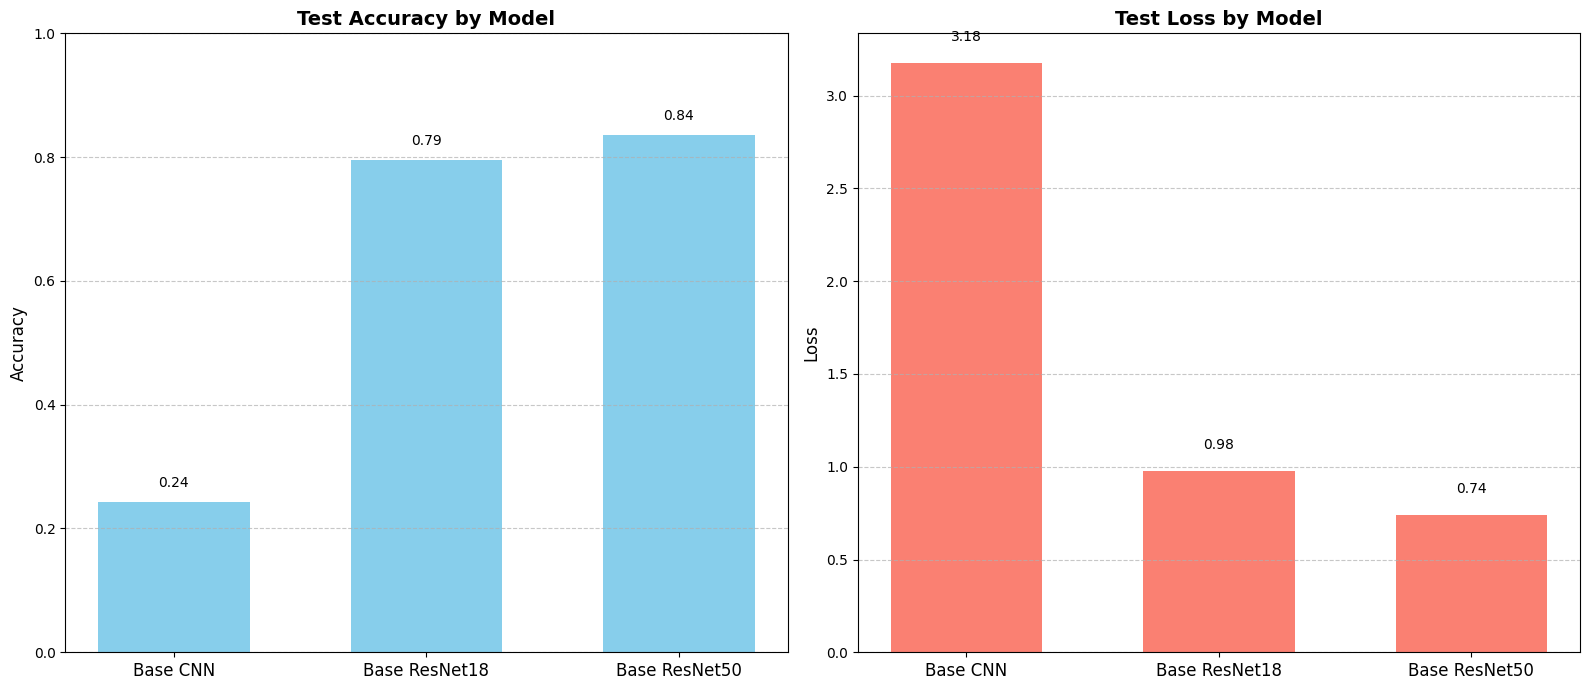

In [60]:
base_model_names = ['Base CNN', 'Base ResNet18', 'Base ResNet50']
# Enable when vit is added
base_model_accuracies = [base_cnn_test_acc, base_resnet18_test_acc, base_resnet50_test_acc]
base_model_losses = [base_cnn_test_loss, base_resnet18_test_loss, base_resnet50_test_loss]
base_training_times = [base_cnn_history['time_taken'], base_resnet18_history['time_taken'], base_resnet50_history['time_taken']]

# Convert the model comparison data into a DataFrame
base_model_comparison_df = pd.DataFrame({
    'Model Name': base_model_names,
    'Accuracy': [acc.item() for acc in base_model_accuracies],  # Convert tensors to floats
    'Loss': base_model_losses,
    'Training Time (s)': base_training_times
})

# Display the DataFrame
display(base_model_comparison_df)

visualization.plot_model_comparison(model_names=base_model_names,
                                    accuracies=base_model_accuracies,
                                    losses=base_model_losses)

### Observations
From the results, it is expected that resnet18 and resnet50 would train faster as we had freezed all the layers except the last conv block and fully connected layer. For our pseudo base CNN model, it took longer to train as we were training the model from scratch, and since it had lesser layers than resnet18 and 50, the accuracy is inherently lower as it is unable to fully capture the fine details of the flowers as compared to the pretrained models which would have better high level feature extraction at the earlier convolutional blocks.

## Training Models with Reduced Parameters

The following models are trained after making changes to the layers by using depthwise convolutions to reduce the parameters and analyze the effects to the initial base model.

The models being trained are:
1. Our light weight baseline CNN model with minimal parameters
2. Pre-trained Resnet18 with fine tuning of last conv block and fc layer
3. Pre-trained Resnet50 with fine tuning of last conv block and fc layer
4. ViT model w prompt tuning

In [61]:
# Setup the save dir of models with reduce parameters
reduced_param_dir = save_dir + "/reduced_parameters"

### Model 1: Base CNN Model with Reduced Parameters
This model is our lightweight baseline CNN model with some conv blocks so as to have a rough gauge on how a small model works against a dataset with minimal training images. We use depthwise+pointwise convolutions to lower the parameters with minimal hit to accuracy

In [62]:
# Set up the model, optimizer and scheduler for training and evaluation
from src.models.lightweight_cnn import LightweightCNN

# Load or train the model
lightweight_cnn, lightweight_cnn_history = load_or_train_model(
    model_name="lightweight_cnn",
    model_class=LightweightCNN,
    save_dir=reduced_param_dir,
    device=device
)

No existing model found. Initializing and training new model: lightweight_cnn
Model Architecture: lightweight_cnn
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          18,496
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
        MaxPool2d-11          [-1, 128, 56, 56]               0
           Conv2d-12          [-1, 128, 56, 56]      

c:\Users\isaac\Documents\GitHub\flowers-recognition\.venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 4.7111 Acc: 0.0216
Learning Rate: 0.001000


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 4.6845 Acc: 0.0108

Epoch 2/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 4.4994 Acc: 0.0363
Learning Rate: 0.001000


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 4.2376 Acc: 0.1029

Epoch 3/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 4.3263 Acc: 0.0569
Learning Rate: 0.001000


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 4.0937 Acc: 0.1088

Epoch 4/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 4.1578 Acc: 0.0873
Learning Rate: 0.001000


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.9727 Acc: 0.1157

Epoch 5/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 4.0457 Acc: 0.0882
Learning Rate: 0.001000


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.8587 Acc: 0.1431

Epoch 6/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.9618 Acc: 0.1078
Learning Rate: 0.001000


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.8145 Acc: 0.1441

Epoch 7/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.8715 Acc: 0.1157
Learning Rate: 0.001000


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.7289 Acc: 0.1500

Epoch 8/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.7811 Acc: 0.1382
Learning Rate: 0.001000


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.6787 Acc: 0.1696

Epoch 9/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.7076 Acc: 0.1490
Learning Rate: 0.001000


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.6171 Acc: 0.1598

Epoch 10/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.6841 Acc: 0.1422
Learning Rate: 0.001000


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.5588 Acc: 0.1765

Epoch 11/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.5872 Acc: 0.1647
Learning Rate: 0.001000


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.5462 Acc: 0.1627

Epoch 12/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.5413 Acc: 0.1755
Learning Rate: 0.001000


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.4898 Acc: 0.1814

Epoch 13/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.4952 Acc: 0.1912
Learning Rate: 0.001000


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.4021 Acc: 0.2078

Epoch 14/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.4623 Acc: 0.2010
Learning Rate: 0.001000


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.4876 Acc: 0.1627

Epoch 15/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.3952 Acc: 0.2000
Learning Rate: 0.001000


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.3548 Acc: 0.2176

Epoch 16/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.3757 Acc: 0.1931
Learning Rate: 0.001000


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.3456 Acc: 0.1941

Epoch 17/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.3375 Acc: 0.2275
Learning Rate: 0.001000


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.3195 Acc: 0.2147

Epoch 18/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.2582 Acc: 0.2186
Learning Rate: 0.001000


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.2624 Acc: 0.2353

Epoch 19/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.2627 Acc: 0.2118
Learning Rate: 0.001000


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.2895 Acc: 0.2118

Epoch 20/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.2031 Acc: 0.2275
Learning Rate: 0.001000


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.1987 Acc: 0.2529

Epoch 21/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.1725 Acc: 0.2422
Learning Rate: 0.001000


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.2292 Acc: 0.2186

Epoch 22/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.1339 Acc: 0.2471
Learning Rate: 0.001000


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.2449 Acc: 0.2304

Epoch 23/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.0992 Acc: 0.2667
Learning Rate: 0.001000


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.1601 Acc: 0.2461

Epoch 24/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.0637 Acc: 0.2794
Learning Rate: 0.001000


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.1514 Acc: 0.2422

Epoch 25/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.0156 Acc: 0.2657
Learning Rate: 0.001000


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.1099 Acc: 0.2402

Training complete in 6m 50s
Best val Acc: 0.252941
Model saved to ./output/saved_models/reduced_parameters\lightweight_cnn.pth
Training history saved to ./output/saved_models/reduced_parameters\lightweight_cnn_history.json
Model trained and saved successfully!


C:\Users\isaac\AppData\Local\Temp\ipykernel_21184\3642648649.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


Testing:   0%|          | 0/193 [00:00<?, ?it/s]

Test Loss: 3.1772 Acc: 0.2428
Final Test Accuracy: 0.2428
Final Test Loss: 3.1772


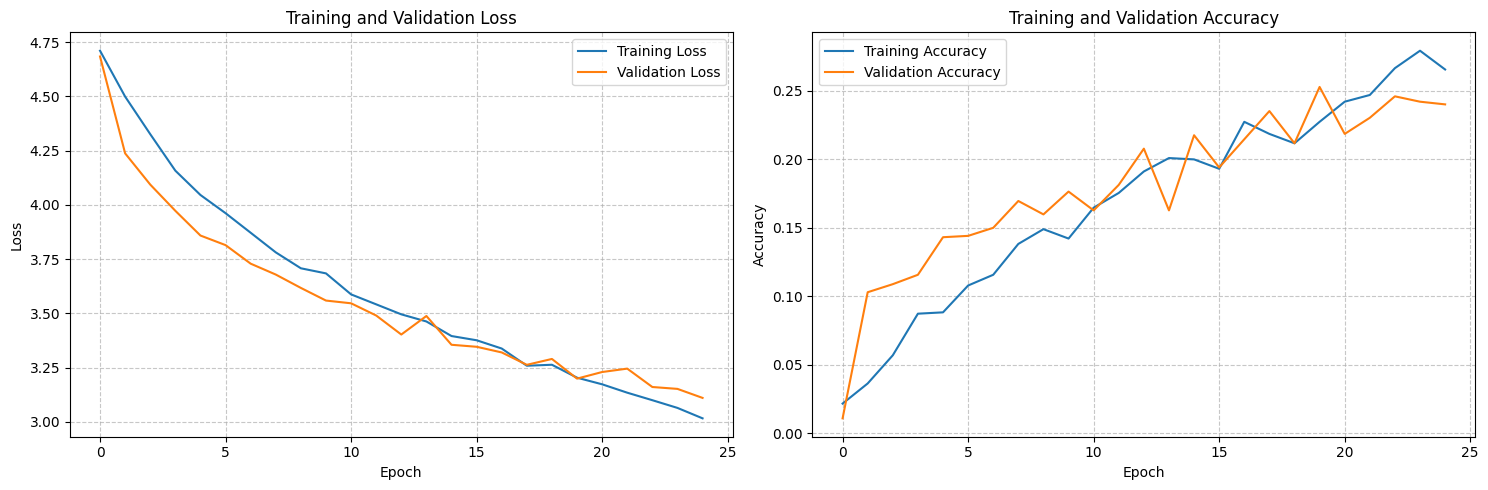

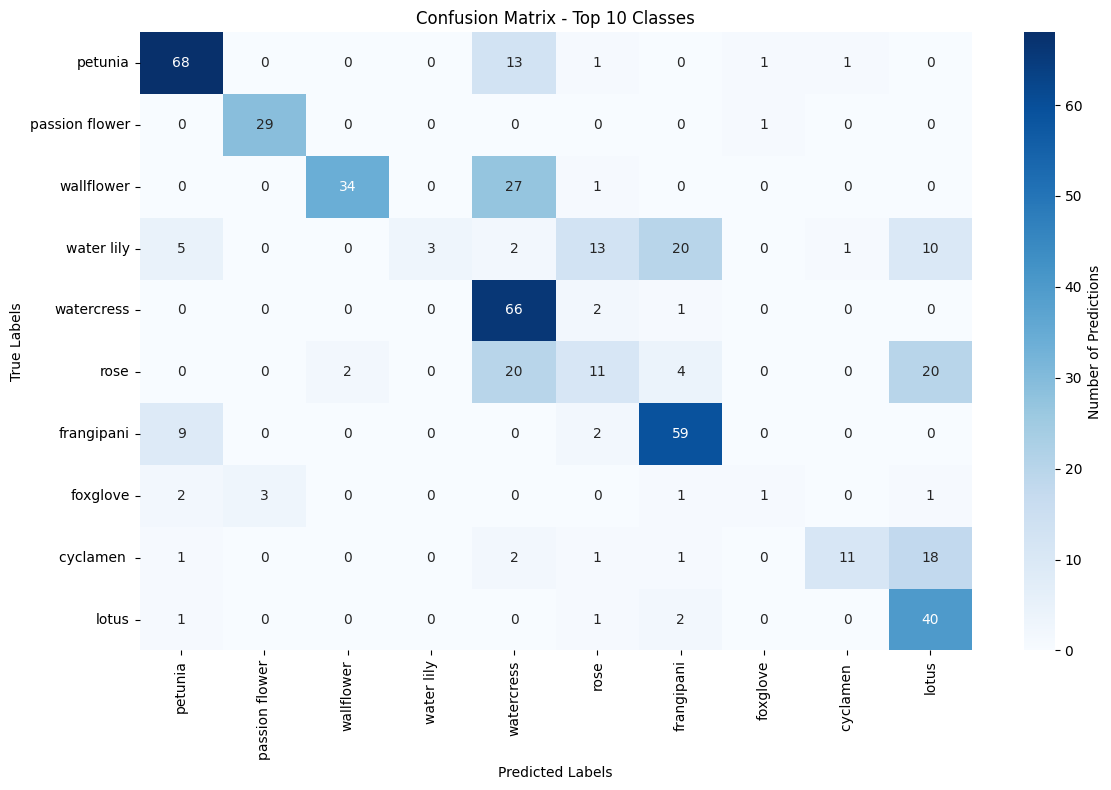

Classification Report - Top 10 Classes:
                precision    recall  f1-score   support

       petunia       0.79      0.81      0.80        84
passion flower       0.91      0.97      0.94        30
    wallflower       0.94      0.55      0.69        62
    water lily       1.00      0.06      0.11        54
    watercress       0.51      0.96      0.66        69
          rose       0.34      0.19      0.25        57
    frangipani       0.67      0.84      0.75        70
      foxglove       0.33      0.12      0.18         8
     cyclamen        0.85      0.32      0.47        34
         lotus       0.45      0.91      0.60        44

      accuracy                           0.63       512
     macro avg       0.68      0.57      0.54       512
  weighted avg       0.70      0.63      0.59       512



In [63]:
# Evaluate the model on the test set
lightweight_cnn_test_loss, lightweight_cnn_test_acc, all_preds, all_labels = evaluate_model(base_cnn, criterion, data_loaders['test'])

# Print final results
print(f"Final Test Accuracy: {lightweight_cnn_test_acc:.4f}")
print(f"Final Test Loss: {lightweight_cnn_test_loss:.4f}")

# Plot training history
visualization.plot_training_history(lightweight_cnn_history)
# Plot confusion matrix
visualization.plot_top_n_confusion_matrix(all_labels, all_preds, flower_labels, top_n=10)

In [64]:
#visualization.visualize_misclassifications_with_closest_images(lightweight_cnn, data_loaders['test'], flower_labels, flowers_dataset['test'])